In [2]:
import random, math, os

from load_and_clean_data import *
from topic_modeling import *
# from sentiment_analysis import *
from nces_dataimport import *

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from scipy.stats import chisquare

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import f1_score, recall_score, precision_score

F:\Programs\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Locate data files

In [3]:
# Determine where the data files are
possible_paths = [
    "F:/Data Files/SI699/", # Jon's Desktop
    "D:/Data Files/SI699/",  # Jon's Laptop
    "C:/Users/nguye/OneDrive/Documents/01-School/06-Winter2019/04-SI699/03-Project/01-Exploration/data" # Tammy's Laptop
]

# see if any of the possible paths are valid
data_path = None
for path in possible_paths:
    if os.path.isdir(path):
        data_path = path
        break

assert data_path is not None
print("Path set as:",data_path)

Path set as: F:/Data Files/SI699/


# Generated Files
This notebook utilizes several files generated by scripts within this repository. If these files do not exist they will be generated here.

**NOTE:** these files can take between 6-7 hours to create

In [4]:
topic_model_file = "topic_model_results.csv"
sentiment_file = "sent_overall.csv"
nces_data_file = "NCES_Data.csv"
projects_file = "clean_projects.csv"

if not os.path.isfile(data_path+topic_model_file):
    print("Creating Topic Models...")
    topic_modeling.do_modeling(data_path+topic_model_file)
    
if not os.path.isfile(data_path+sentiment_file):
    print("Creating Sentiment Analysis...")
    sentiment_analysis.do_sentiment_analysis()
    
if not os.path.isfile(data_path+nces_data_file):
    print("Loading NCES Data...")
    nces_dataimport.do_import(data_path, nces_data_file)
    
if not os.path.isfile(data_path + projects_file):
    print("Loading and cleaning projects dataframe (will take a few minutes)...")
    load_projects(data_path, data_path + projects_file)

In [5]:
%%time
# load in the projects dataframe
projects_file = data_path+"clean_projects.csv"
projects_df = pd.read_csv(
    projects_file, 
    index_col=0,
    dtype={
        "school_metro":"category",
        "teacher_prefix":"category",
        "primary_focus_subject":"category",
        "primary_focus_area":"category",
        "secondary_focus_subject":"category",
        "secondary_focus_area":"category",
        "resource_type":"category",
        "poverty_level":"category",
        "grade_level":"category",
        "month_posted":"category",
        "funding_status":"category"
    }
)

Wall time: 29.9 s


In [6]:
print("Dataset sizes:")
print("projects_df: {0:,} rows, {1} variables".format(*projects_df.shape))

Dataset sizes:
projects_df: 1,130,546 rows, 107 variables


Load in the NCES Data

In [6]:
NCES_df = pd.read_csv(data_path + "NCES_Data.csv")
NCES_df.rename(columns={"NCESSCH":"school_ncesid"}, inplace=True)
NCES_df['school_ncesid'] = NCES_df['school_ncesid'].apply(lambda x: str(x).zfill(12))
NCES_df.head()

,school_ncesid,date_posted,year,MCITY,MSTATE,MZIP,MZIP4,PHONE,LCITY,LSTATE,...,HIALF,BLALM,BLALF,WHALM,WHALF,FTE,TOTFRL,FRELCH,REDLCH,TITLEI
0,362058000623,2002-10-27,2002,NEW YORK,NY,10002,1398.0,2126738254,NEW YORK,NY,...,-2,-2,-2,-2,-2,-1.0,-2,-2,-2,2
1,362058000623,2002-11-05,2002,NEW YORK,NY,10002,1398.0,2126738254,NEW YORK,NY,...,-2,-2,-2,-2,-2,-1.0,-2,-2,-2,2
2,362058000623,2002-11-11,2002,NEW YORK,NY,10002,1398.0,2126738254,NEW YORK,NY,...,-2,-2,-2,-2,-2,-1.0,-2,-2,-2,2
3,362058000623,2002-11-11,2002,NEW YORK,NY,10002,1398.0,2126738254,NEW YORK,NY,...,-2,-2,-2,-2,-2,-1.0,-2,-2,-2,2
4,362058000623,2002-11-28,2002,NEW YORK,NY,10002,1398.0,2126738254,NEW YORK,NY,...,-2,-2,-2,-2,-2,-1.0,-2,-2,-2,2


In [7]:
# Try to convert each of the columns to integers.
# Some are not integers, and we expect them to fail
for col in NCES_df.columns[15:]:
    try:
        NCES_df[col] = NCES_df[col].astype("int8")
    except:
        print("Can't convert to int:",col)

Can't convert to int: TITLEI


In [8]:
projects_df = projects_df[projects_df['school_ncesid'].notnull()]
projects_df.school_ncesid = projects_df.school_ncesid.astype("int64")
projects_df.school_ncesid = projects_df.school_ncesid.apply(lambda x: str(x).zfill(12))

projects_df.date_posted = pd.to_datetime(projects_df.date_posted)
projects_df['year'] = projects_df.date_posted.apply(lambda x: x.year if x.month > 6 else x.year-1)
projects_df.head()

,_projectid,_teacher_acctid,_schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,Focus_Subject_Performing Arts,Focus_Subject_Social Sciences,Focus_Subject_Special Needs,Focus_Subject_Team Sports,Focus_Subject_Visual Arts,poverty_level_code,grade_level_code,LOG_total_price,LOG_students_reached,year
0,7342bd01a2a7725ce033a179d22e382d,5c43ef5eac0f5857c266baa1ccfa3d3f,9e72d6f2f1e9367b578b6479aa5852b7,360009702803,40.688454,-73.910432,New York City,NY,11207.0,urban,...,0,0,0,0,0,3,3.0,5.632179,0.0,2002
1,ed87d61cef7fda668ae70be7e0c6cebf,1f4493b3d3fe4a611f3f4d21a249376a,1ae4695be589a36816188e2b301a0395,360007700585,40.765517,-73.960090,New York City,NY,10065.0,NaN,...,0,0,0,0,0,3,4.0,5.026771,0.0,2002
2,b56b502d25666e29550d107bf7e17910,57426949b47700ccf62098e1e9b0220c,4a06a328dd87bd29892d73310052f45f,360007702569,40.770233,-73.950760,New York City,NY,10075.0,NaN,...,0,0,0,0,0,1,2.0,5.026771,0.0,2002
3,016f03312995d5c89d6b348be4682166,9c0aa56b63b743454d6da9effcf122fc,bb0af5dac1b54693ba86ef63eacd6594,360007605617,40.727826,-73.978721,New York City,NY,10009.0,urban,...,0,0,0,0,0,2,1.0,5.429565,0.0,2002
4,cf6275558534ca1b276b0d8d5130dd9a,1d4d8a42730dbb66af1ebb6ab37456b7,768dab263f87881fe7c68ffb3965df7c,360008302472,40.841216,-73.938605,New York City,NY,10032.0,urban,...,0,0,0,0,0,3,1.0,5.679080,0.0,2002


In [9]:
projects_df = projects_df.merge(NCES_df, on=['school_ncesid', 'year'])
%xdel NCES_df

Load in the Topic Modeling Data

In [7]:
topics_df = pd.read_csv(data_path + "topic_model_results.csv")
topic_dummies = pd.get_dummies(topics_df['Topic_1'].astype("int").astype("category"))
topic_dummies.columns = ["Topic_"+str(x+1) for x in range(12)]
topics_df = topics_df[["_projectid"]].merge(topic_dummies, left_index=True, right_index=True)
projects_df = projects_df.merge(topics_df, on='_projectid')

%xdel topic_dummies
%xdel topics_df

In [8]:
sentiment_df = pd.read_csv(sentiment_file, index_col=['_projectid'])
sentiment_df.head(1)

,entire_essay_compound,entire_essay_neg,entire_essay_neu,entire_essay_pos,first_sentence_compound,first_sentence_neg,first_sentence_neu,first_sentence_pos
_projectid,,,,,,,,
0000023f507999464aa2b78875b7e5d6,0.9502,0.051,0.846,0.103,0.2263,0.0,0.808,0.192


In [9]:
projects_df = projects_df.merge(sentiment_df, left_on="_projectid", right_index=True)
%xdel sentiment_df

# Chi Square Feature Testing (Top 10)

In [10]:
# List of all relevant columns
column_names = [col for col in projects_df.select_dtypes(["int64", "int32", "uint8"]).columns if col not in ["week_of_year_posted", "poverty_level_code"]]

In [11]:
# Chi2 Analysis
from scipy.stats import chi2_contingency

chi2_dict = {}

for each in column_names:
    cross = pd.crosstab(projects_df.funding_status, projects_df[each])
    chi2_object = chi2_contingency(cross)
    chi2_dict[each] = chi2_object[1]

In [12]:
# Ranking the Features by P-Values
ranked_features = sorted(chi2_dict.items(), key=lambda x: x[1])

for each in ranked_features[:20]:
    print(each)

('teacher_teach_for_america', 0.0)
('rural', 0.0)
('urban', 0.0)
('Mrs.', 0.0)
('Ms.', 0.0)
('April', 0.0)
('May', 0.0)
('September', 0.0)
('high poverty', 0.0)
('highest poverty', 0.0)
('Resource_Books', 0.0)
('Resource_Supplies', 0.0)
('Resource_Technology', 0.0)
('Topic_2', 0.0)
('Topic_4', 0.0)
('suburban', 1.974646712211835e-279)
('June', 6.240518009297924e-258)
('Focus_Subject_Other', 1.758107838614048e-253)
('December', 4.177492752855517e-228)
('moderate poverty', 7.577342279640103e-206)


In [29]:
classifier_col_list = [col[0] for col in ranked_features[:20]] + ['LOG_total_price', 'total_price_including_optional_support']

# (Optional) Set a subset of the data to create a train/dev/test split from

In [14]:
data_df = projects_df

# Create a training, dev and test set

In [15]:
# Makes a 72/8/20 train/dev/test split
training_df, test_df = train_test_split(data_df, test_size=0.2)
training_df, dev_df = train_test_split(training_df, test_size=0.1)
print("Training Set: {:,} rows. Test Set: {:,} rows. Dev Set: {:,} rows.".format(training_df.shape[0], test_df.shape[0], dev_df.shape[0]))

# Create a balanced training set from the training set we just made
# The dev set is just a 1/4 sample of the new set

# get the size of the smallest of the two datasets - completed or expired
fewest_rows = min(training_df[training_df.funding_status=='completed'].shape[0],training_df[training_df.funding_status=='expired'].shape[0])
# there's got to be a better way of doing this. If the smaller is 245,000, I want 200,000. If it's 76,000, I want 70,000.
set_size = 10**(len(str(fewest_rows))-1)*int(str(fewest_rows)[0])

balanced_training_df = pd.concat(
    [training_df[training_df.funding_status=='completed'].sample(set_size),
     training_df[training_df.funding_status=='expired'].sample(set_size)])
balanced_dev_df = balanced_training_df.sample(int(set_size*0.25))
print("Balanced Training Set: {:,} rows. Balanced Dev Set: {:,} rows.".format(balanced_training_df.shape[0], balanced_dev_df.shape[0]))

Training Set: 811,888 rows. Test Set: 225,525 rows. Dev Set: 90,210 rows.
Balanced Training Set: 400,000 rows. Balanced Dev Set: 50,000 rows.


# Crosstab Heatmaps

In [16]:
def get_count_table(col_name):
    print()
    print("Counts for",col_name)
    counts_df = pd.DataFrame(projects_df[col_name].value_counts())
    counts_df.rename(columns={col_name:"count"}, inplace=True)
    counts_df['percent'] = counts_df['count']/counts_df['count'].sum()
    return counts_df

In [17]:
def create_crosstab_heatmap(first_col_name, second_col_name='funding_status', df=training_df, norm='all', filename=None):   
    ct = pd.crosstab(df[second_col_name], df[first_col_name], normalize=norm)
    ct.sort_values("completed", axis=1, inplace=True)
    
    if df[first_col_name].nunique() > 20:
        w = df[first_col_name].nunique()
    else:
        w = df[first_col_name].nunique() * 2
        print(get_count_table(first_col_name))
        
    fig, ax = plt.subplots()
    fig.set_size_inches(w,6)
    sns.heatmap(ct, annot=True, ax=ax, cmap="Blues")
    
    if filename is not None:
        plt.savefig(filename)


Counts for school_metro
           count   percent
urban     569014  0.572178
suburban  317276  0.319040
rural     108180  0.108782

Counts for teacher_prefix
             count   percent
Mrs.        561025  0.497549
Ms.         424147  0.376158
Mr.         137149  0.121631
Teacher       5022  0.004454
Dr.            233  0.000207
Mr. & Mrs.       2  0.000002

Counts for primary_focus_area
                      count   percent
Literacy & Language  482663  0.428045
Math & Science       298644  0.264849
Music & The Arts      99354  0.088111
Applied Learning      76663  0.067988
Special Needs         73744  0.065399
History & Civics      48582  0.043084
Health & Sports       47949  0.042523

Counts for secondary_focus_area
                      count   percent
Literacy & Language  271295  0.350910
Math & Science       196636  0.254342
Applied Learning     105997  0.137103
History & Civics      58314  0.075427
Music & The Arts      55151  0.071336
Special Needs         47705  0.061705
Hea

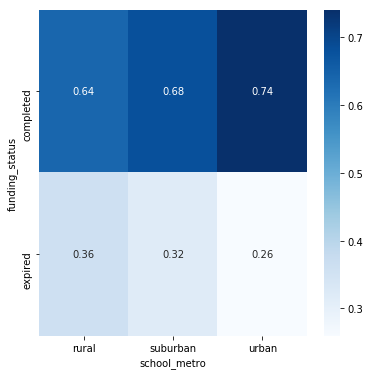

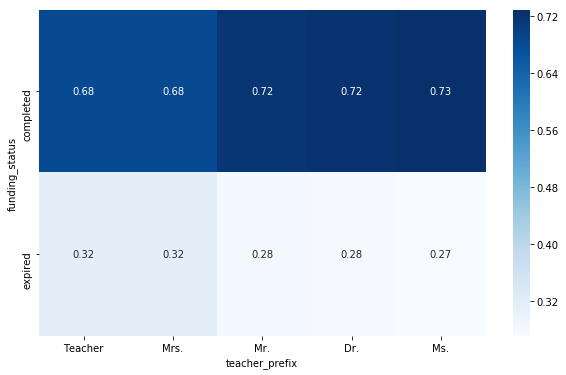

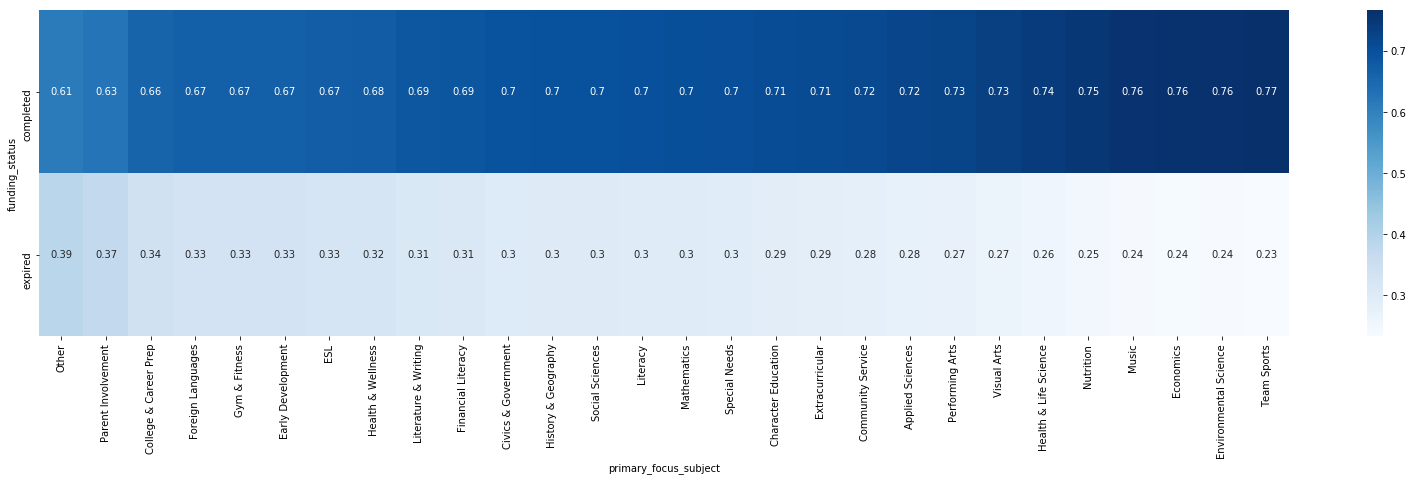

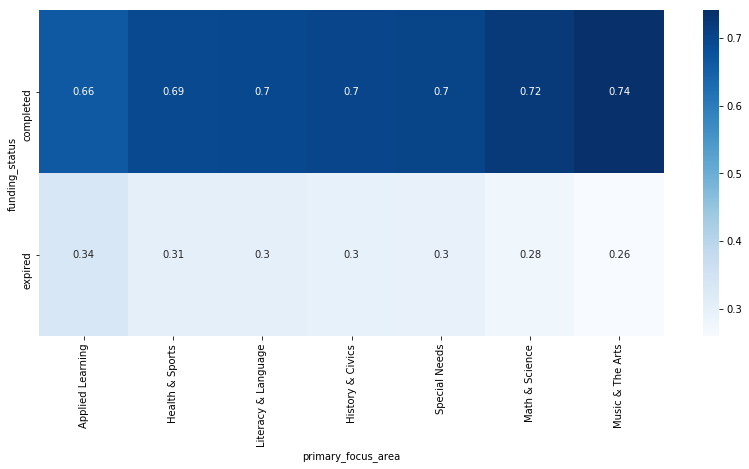

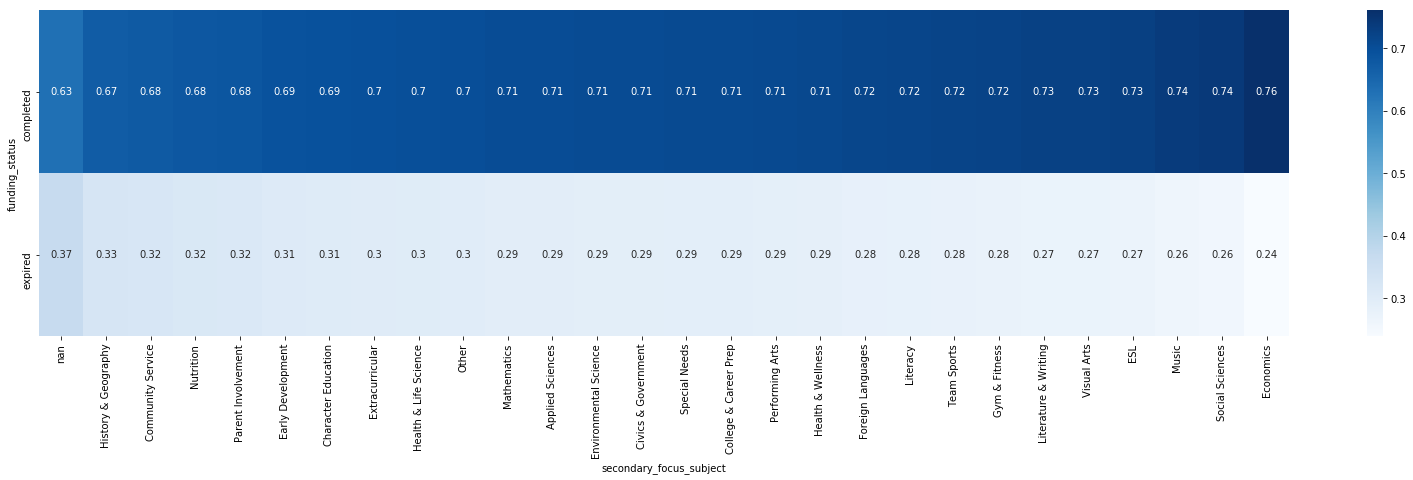

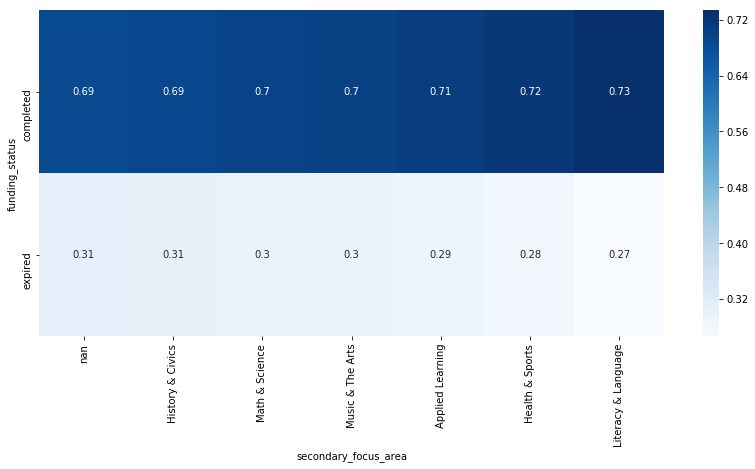

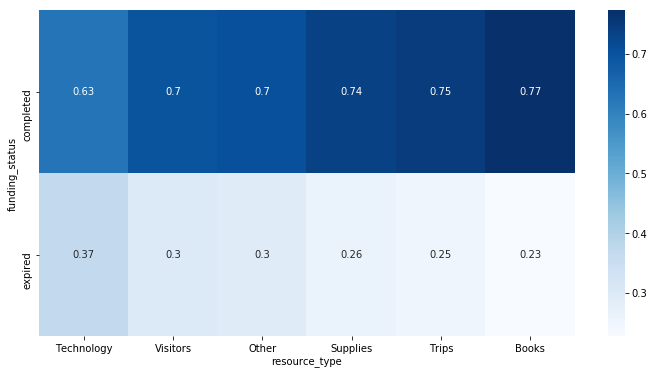

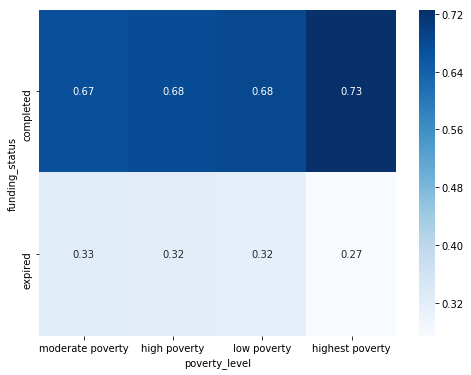

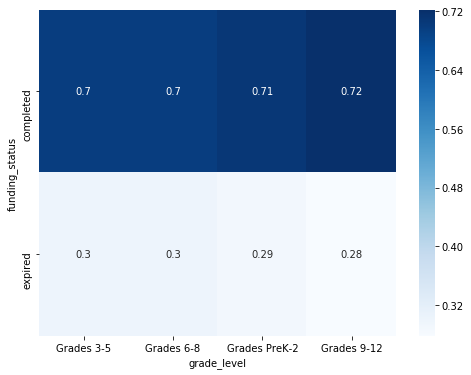

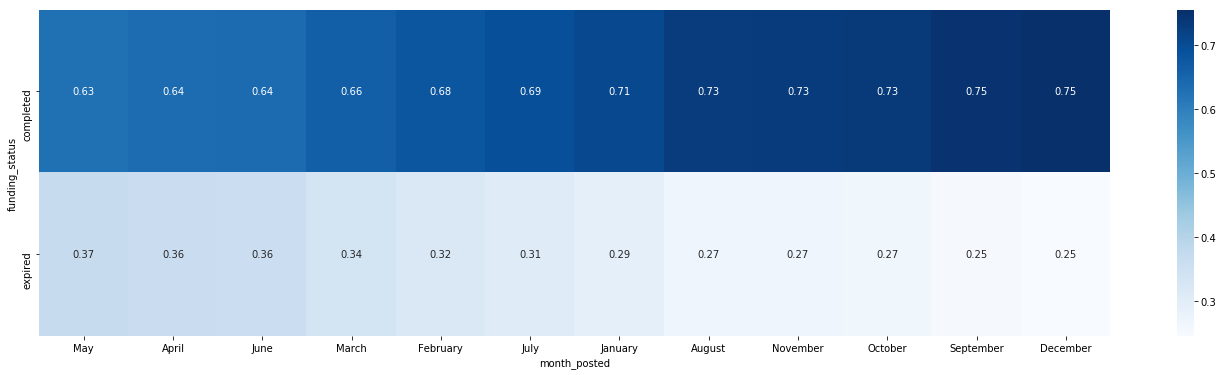

In [18]:
%%time
# Make crosstab heatmaps for each categorical and boolean column
for col_name in projects_df.select_dtypes(['category', 'bool']).columns:
    if col_name != "funding_status":
        create_crosstab_heatmap(col_name, norm='columns')


Counts for primary_focus_area
                      count   percent
Literacy & Language  482663  0.428045
Math & Science       298644  0.264849
Music & The Arts      99354  0.088111
Applied Learning      76663  0.067988
Special Needs         73744  0.065399
History & Civics      48582  0.043084
Health & Sports       47949  0.042523


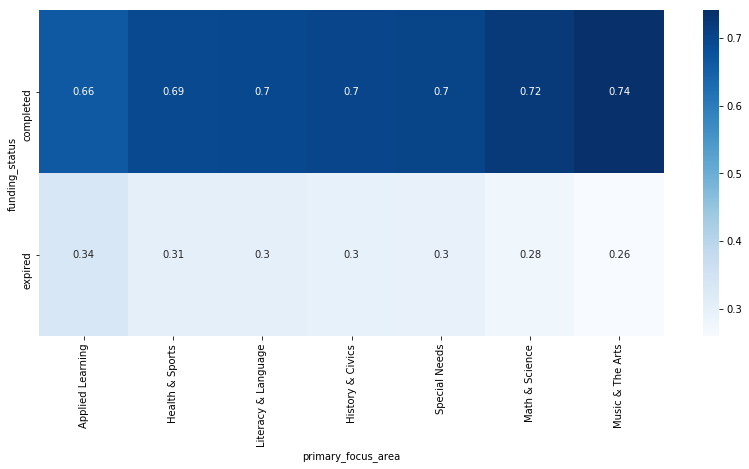

In [19]:
create_crosstab_heatmap("primary_focus_area", filename="primary_focus_area_heatmap.png", norm='columns')

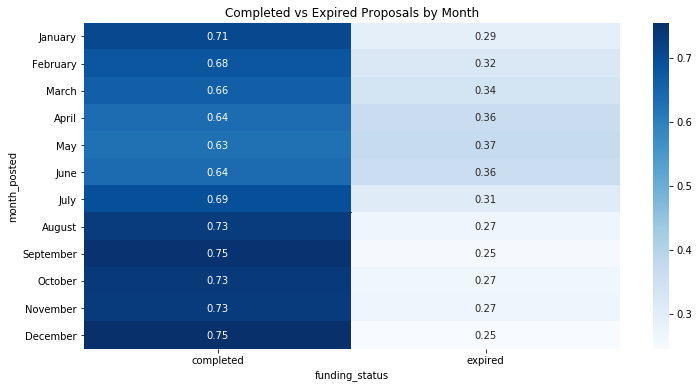

In [20]:
ct = pd.crosstab(training_df['month_posted'], training_df['funding_status'], normalize='index')
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sns.heatmap(ct.reindex(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]), annot=True, ax=ax, cmap="Blues").set_title("Completed vs Expired Proposals by Month")
plt.savefig("funding_by_month.png")

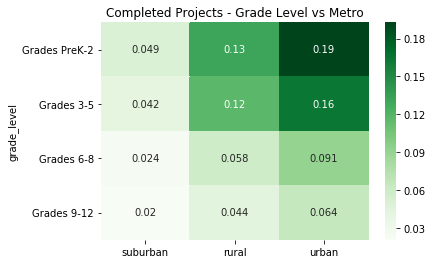

In [21]:
completed_df = training_df[training_df.funding_status=="expired"]
ct = pd.crosstab(
    completed_df['grade_level'], 
    completed_df['school_metro'],
    normalize='all'
)
ct = ct.reindex(["Grades PreK-2","Grades 3-5", "Grades 6-8", "Grades 9-12"])
ct.columns=['suburban', 'rural', 'urban']

fig, ax = plt.subplots()
fig.set_size_inches(6,4)
sns.heatmap(ct, annot=True, ax=ax, cmap="Greens").set_title("Completed Projects - Grade Level vs Metro")
plt.savefig("grade_vs_metro.png", bbox_inches='tight')

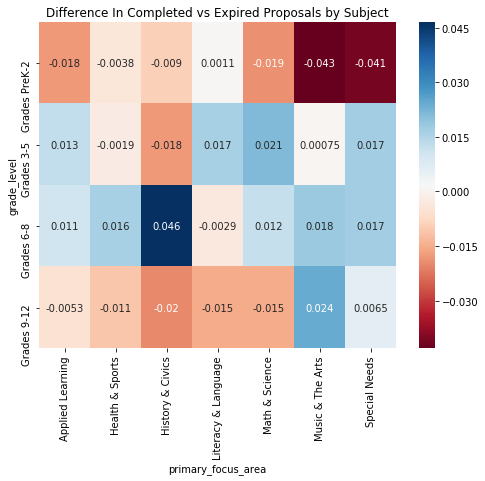

In [22]:
completed_df = training_df[(training_df.funding_status=="completed")&(~training_df.resource_type.isin(["Other", "Visitors", "Trips"]))]
ct_completed = pd.crosstab(
    completed_df['grade_level'], 
    completed_df['primary_focus_area'], 
    normalize='columns'
)
completed_df = training_df[(training_df.funding_status=="expired")&(~training_df.resource_type.isin(["Other", "Visitors", "Trips"]))]
ct_expired = pd.crosstab(
    completed_df['grade_level'], 
    completed_df['primary_focus_area'], 
    normalize='columns'
)
ct = ct_expired.subtract(ct_completed)
ct = ct.reindex(["Grades PreK-2","Grades 3-5", "Grades 6-8", "Grades 9-12"])

fig, ax = plt.subplots()
fig.set_size_inches(8,6)
sns.heatmap(ct, annot=True, ax=ax, cmap="RdBu").set_title("Difference In Completed vs Expired Proposals by Subject")
plt.savefig("grade_by_subject.png", bbox_inches='tight')

# Classifier Setup

In [23]:
# Scores a list of predictions against the test set
# requires a list the same length as test_df comprised of either 0 or 1
# params:
#     predictions: an array of 0 and 1 predictions
#     verbose: prints the F1, Precision, and Recall Scores
# returns:
#     a tuple with (F1, Precision, Recall)
def Score(predictions, verbose=False):
    f1 = f1_score(y_pred=predictions, y_true=test_df.funding_status.cat.codes)
    p = precision_score(y_pred=predictions, y_true=test_df.funding_status.cat.codes)
    r = recall_score(y_pred=predictions, y_true=test_df.funding_status.cat.codes)
    
    if verbose: 
        print("F1: {:.4} (Precision: {:.4}, Recall: {:.4})".format(f1, p,r))
        
    return f1, p, r

In [24]:
# Scores a classifier against the test set
# requires a list the same length as test_df comprised of either 0 or 1
# params:
#     clf: an sklearn classifier
#     train_df: the training set to train the classifier on
#     verbose: prints the F1, Precision, and Recall Scores
# returns:
#     a tuple with (F1, Precision, Recall)
def Score_Classifier(clf, train_df, verbose=False):
    clf.fit(X=train_df[classifier_col_list], y=train_df['funding_status'].cat.codes)
    predictions = clf.predict(test_df[classifier_col_list].values)
    
    f1 = f1_score(y_pred=predictions, y_true=test_df.funding_status.cat.codes)
    p = precision_score(y_pred=predictions, y_true=test_df.funding_status.cat.codes)
    r = recall_score(y_pred=predictions, y_true=test_df.funding_status.cat.codes)
    
    if verbose: 
        print("F1: {:.4} (Precision: {:.4}, Recall: {:.4})".format(f1, p,r))
        
    return f1, p, r

# Greedy Feature Selection
(Ignored at the moment. ~25min wall time)

In [25]:
%%time
# Create a Logistic Regression Classifier 
def make_logistic_regressor(columns):
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(dev_df[columns].values, dev_df.funding_status.cat.codes)
    predictions = clf.predict(test_df[columns].values)
    return Score(predictions)

# Set to True to run greedy feature selection using the logistic regression classifier
if False:
    columns_to_ignore = [
        'school_metro', 'teacher_prefix', 'resource_type', 'primary_focus_area', 'primary_focus_subject', 'secondary_focus_subject', 'secondary_focus_area', 'month_posted', 'day_of_week_posted', 'poverty_level', 'grade_level'
    ]
    columns_to_try = [x for x in list(test_df.columns) if x not in columns_to_ignore+['funding_status']]

    best = []
    for x in range(20):
        current_best = (None, 0)
        for col in columns_to_try:
            f1, p,r = make_logistic_regressor([col]+[x[0] for x in best])
            if f1 > current_best[1]:
                current_best = (col, f1)
        print(current_best)
        best.append(current_best)
        columns_to_try.remove(current_best[0])
    
    results_df = pd.DataFrame(best)
    results_df.columns=["feature", "f1"]
    results_df.set_index("feature", inplace=True)
    results_df['f1_improvement'] = results_df['f1'].diff()
    results_df[['f1', 'f1_improvement']]

Wall time: 0 ns


# Classifiers
F1, Precision and Recall of each classifier is stored in an array for comparison

In [26]:
model_results = []

In [27]:
%%timeit
# Random Chance Baseline
results = []
for x in range(test_df.shape[0]):
    if random.random() < 0.704947:
        results.append(1)
    else:
        results.append(0)
model_results.append(["Random", Score(results, True)])

F1: 0.4136 (Precision: 0.2933, Recall: 0.7007)
F1: 0.4162 (Precision: 0.2951, Recall: 0.706)
F1: 0.4154 (Precision: 0.2945, Recall: 0.7048)
F1: 0.4154 (Precision: 0.2946, Recall: 0.7045)
F1: 0.4153 (Precision: 0.2945, Recall: 0.704)
F1: 0.4162 (Precision: 0.2952, Recall: 0.7052)
F1: 0.4156 (Precision: 0.2948, Recall: 0.7047)
F1: 0.4171 (Precision: 0.296, Recall: 0.7057)
378 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%%time
clf = LogisticRegression(penalty='l2', class_weight='balanced')
model_results.append([
        "LogisticRegression",
        Score_Classifier(clf, train_df=training_df, verbose=True)])

F1: 0.5044 (Precision: 0.4232, Recall: 0.6242)
Wall time: 14.2 s


In [31]:
%%time
clf = RandomForestClassifier(n_estimators=20, max_depth=10)
model_results.append([
        "RandomForestClassifier",
        Score_Classifier(clf, train_df=balanced_training_df, verbose=True)])

F1: 0.5111 (Precision: 0.4065, Recall: 0.6881)
Wall time: 10.9 s


In [35]:
%%time
clf = AdaBoostClassifier()
model_results.append([
        "AdaBoostClassifier",
        Score_Classifier(clf, train_df=balanced_training_df, verbose=True)])

F1: 0.5107 (Precision: 0.4162, Recall: 0.6609)
Wall time: 24.2 s


In [36]:
%%time
clf = GradientBoostingClassifier(loss='exponential', max_depth=10, max_features=7)
model_results.append([
        "GradientBoostingClassifier",
        Score_Classifier(clf, train_df=balanced_training_df, verbose=True)]) # high: 0.5206 (0.4214, 0.6811)

F1: 0.5134 (Precision: 0.4144, Recall: 0.6746)
Wall time: 7min 4s


In [37]:
%%time
clf = ExtraTreesClassifier(n_estimators=25, max_depth=10, max_features=17)
model_results.append([
        "ExtraTreesClassifier",
        Score_Classifier(clf, train_df=balanced_training_df, verbose=True)])

F1: 0.5101 (Precision: 0.4112, Recall: 0.6718)
Wall time: 30.7 s


In [38]:
%%time
clf = MultinomialNB()
model_results.append([
        "MultinomialNB",
        Score_Classifier(clf, train_df=balanced_training_df, verbose=True)])

F1: 0.4321 (Precision: 0.4513, Recall: 0.4144)
Wall time: 530 ms


In [39]:
%%time
clf = BernoulliNB()
model_results.append([
        "BernoulliNB",
        Score_Classifier(clf, train_df=balanced_training_df, verbose=True)])

F1: 0.4437 (Precision: 0.3677, Recall: 0.5595)
Wall time: 880 ms


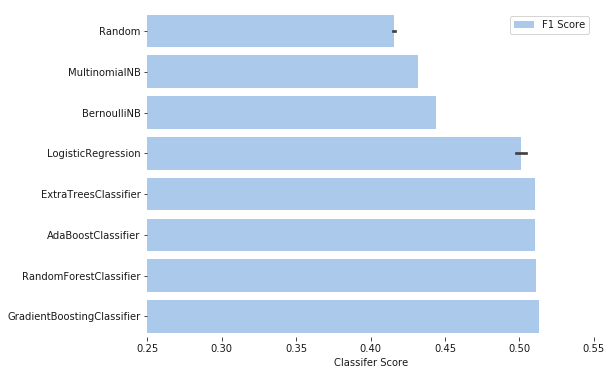

In [40]:
classifiers = pd.DataFrame([{
    "Classifier":x[0], 
    "F1":x[1][0],
    "Precision":x[1][1],
    "Recall":x[1][2]
} for x in model_results])
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
sns.set_color_codes("pastel")
sns.barplot(data=classifiers.sort_values("F1"), y="Classifier", x="F1", ax=ax, color="b", label="F1 Score")

# sns.set_color_codes("deep")
# sns.barplot(data=classifiers.sort_values("F1"), y="Classifier", x="Precision", ax=ax, color="b", label="Precision")

ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(xlim=(.25, .55), ylabel="",
       xlabel="Classifer Score")
sns.despine(left=True, bottom=True)

# plt.savefig("classifiers.png", bbox_inches='tight')

In [41]:
classifiers

,Classifier,F1,Precision,Recall
0,Random,0.413558,0.293346,0.700704
1,Random,0.416229,0.295103,0.706011
2,Random,0.415412,0.294488,0.704838
3,Random,0.415447,0.294581,0.704507
4,Random,0.415252,0.294471,0.704011
5,Random,0.416174,0.295191,0.705199
6,Random,0.415646,0.294752,0.704673
7,Random,0.417112,0.296040,0.705740
8,LogisticRegression,0.497613,0.417057,0.616739
9,LogisticRegression,0.504392,0.423171,0.624196


# Hyperparameter Tuning
Light tuning at the moment, just to get a ballpark idea of what good parameters look like

In [ ]:
# Performs a Grid Search of the provided parameters to find the best options for a given classifier
# params:
#     clf: the classifier to use
#     param_grid: a dictionary of the parameters the classifier can use
#     df_set: a string indicating which set to train on (can be "training" (default), "balanced" or "scaled")
#     verbose: (default 0) if set to 1 or True, will provide prints regarding the status of the search
# returns:
#     a tuple with (F1, Precision, Recall) of the best classifier parameters
def HyperParam_Search(clf, param_grid, df_set="training", verbose=0):
    if df_set == "training":
        df = training_df
        d_df = dev_df
    elif df_set == "balanced":
        df = balanced_training_df
        d_df = balanced_dev_df
    elif df_set == "scaled":
        df = balanced_scaled_training_df
        d_df = balanced_scaled_dev_df
    gscv = GridSearchCV(cv=2,estimator=clf, param_grid=param_grid, n_jobs=-1, verbose=verbose)
    gscv.fit(d_df[classifier_col_list], d_df['funding_status'].cat.codes)
    print(gscv.best_estimator_)
    return Score_Classifier(gscv.best_estimator_, df)

In [ ]:
%%time
param_grid = {
    "penalty":['l1', 'l2'],
    "class_weight":['balanced', None]
}
model_results.append([
        "LogisticRegression",
        HyperParam_Search(LogisticRegression(), param_grid, df_set="balanced", verbose=1)])

In [ ]:
%%time
param_grid = {
    "n_estimators":[15, 20, 25],
    "max_depth":[10, 15, 20],
    "max_features":[x for x in range(1, len(classifier_col_list), round(len(classifier_col_list)/4))]
}
model_results.append([
        "RandomForestClassifier",
        HyperParam_Search(RandomForestClassifier(), param_grid, df_set="balanced", verbose=1)])

In [ ]:
%%time
param_grid = {
    "loss":['deviance', 'exponential'],
    "max_depth":[10, 15, 20],
    "max_features":[x for x in range(1, len(classifier_col_list), round(len(classifier_col_list)/3))]
}
model_results.append([
        "GradientBoostingClassifier",
        HyperParam_Search(GradientBoostingClassifier(), param_grid, df_set="balanced", verbose=1)])

In [ ]:
%%time
param_grid = {
    "n_estimators":[15, 20, 25],
    "max_depth":[10, 15, 20],
    "max_features":[x for x in range(1, len(classifier_col_list), round(len(classifier_col_list)/3))]
}

model_results.append([
        "ExtraTreesClassifier",
        HyperParam_Search(ExtraTreesClassifier(), param_grid, df_set="balanced", verbose=1)])

In [ ]:
%%time
param_grid = {
    "alpha":[1,.2,.8,1]
}

model_results.append([
        "BernoulliNB",
        HyperParam_Search(BernoulliNB(), param_grid, df_set="balanced", verbose=1)])

In [ ]:
%%time
param_grid = {
    "alpha":[1,.2,.8,1]
}

model_results.append([
        "MultinomialNB",
        HyperParam_Search(MultinomialNB(), param_grid, df_set="balanced", verbose=1)])

In [ ]:
%%time
param_grid = {
    "C":[1.0, 0.1],
    "class_weight":[None, 'balanced']
}

model_results.append([
        "LinearSVC",
        HyperParam_Search(LinearSVC(), param_grid, df_set="scaled", verbose=1)])